In [1]:
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')
from sim import make_dataset
from util import show_dataset

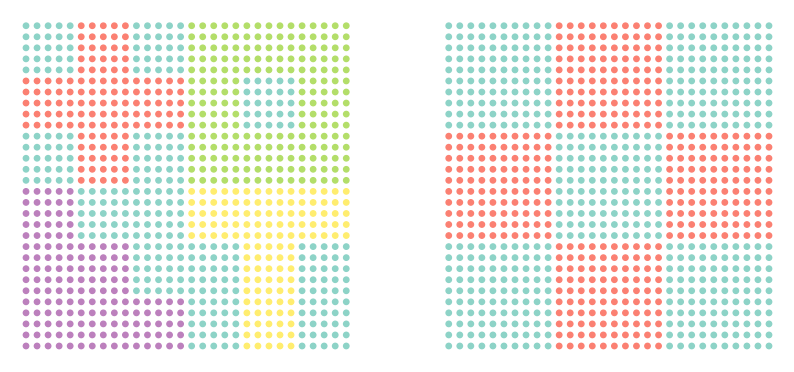

In [2]:
data, labels = make_dataset(('polygons', 'checkers'), (5, 10))
show_dataset(data, labels)